## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

In [ ]:
# 1. RESTART RUNTIME FIRST (Runtime → Restart runtime)

# 2. RUN THIS EXACT BLOCK (copy-paste & run ONCE)
!pip install --quiet --force-reinstall \
    "numpy==1.26.4" \
    "gensim==4.3.3" \
    "scipy==1.12.0" \
    "spacy==3.7.2" \
    "transformers==4.45.2" \
    "torch==2.4.1+cpu" \
    "torchvision==0.19.1+cpu" \
    "torchaudio==2.4.1+cpu" \
    "tensorflow==2.17.0" \
    "keras==3.4.1" \
    --extra-index-url https://download.pytorch.org/whl/cpu

!python -m spacy download en_core_web_lg -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
optax 0.2.6 requires jax>=0.5.3, which is not installed.
optax 0.2.6 requires jaxlib>=0.5.3, which is not installed.
orbax-checkpoint 0.11.26 requires jax>=0.6.0, which is not installed.
chex 0.1.90 requires jax>=0.4.27, which is not installed.
chex 0.1.90 requires jaxlib>=0.4.27, which is not installed.
flax 0.10.7 requires jax>=0.6.0, which is not installed.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you

In [ ]:
import numpy as np
import gensim
import spacy
import torch
import transformers
import tensorflow as tf
import keras
from gensim.models import Word2Vec
from transformers import pipeline

print("All libraries imported successfully!")
print(f"NumPy: {np.__version__} | Gensim: {gensim.__version__} | Torch: {torch.__version__}")
print(f"TF: {tf.__version__} | Keras: {keras.__version__}")

# Test spaCy
nlp = spacy.load("en_core_web_lg")
doc = nlp("This is a test.")
print("spaCy model loaded and working:", [token.text for token in doc])

All libraries imported successfully!
NumPy: 1.26.4 | Gensim: 4.3.3 | Torch: 2.4.1+cpu
TF: 2.17.0 | Keras: 3.4.1
spaCy model loaded and working: ['This', 'is', 'a', 'test', '.']


In [ ]:

import pandas as pd
import re, string, warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer
from typing import List, Callable, Dict, Tuple, Set

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as K

from transformers import pipeline

# --- NLP Resource Downloads ---
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

print("NLTK & spaCy setup complete — Environment ready for Bridesmaids Ontology and Knowledge Graph Assignment ")


NLTK & spaCy setup complete — Environment ready for Bridesmaids Ontology and Knowledge Graph Assignment 


## Data Wrangling Utility Functions

In [ ]:

import numpy as np
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from typing import List



# 1. Load Class Corpus (from GitHub)

url = "https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20250924.csv"
df = pd.read_csv(url)
print(f" Loaded class corpus with shape: {df.shape}")
print(" Columns:", list(df.columns))

#  Filter your 10 Bridesmaids reviews (Doc_ID 201–210)
docs_subset = df[df['Doc_ID'].between(201, 210)].reset_index(drop=True)
print(f" Filtered subset shape: {docs_subset.shape}")
display(docs_subset[['Doc_ID', 'Movie Title', 'Genre of Movie', 'Review Type (pos or neg)']].head())

# 2. Text Cleaning Helpers

def clean_doc(doc: str) -> str:
    """
    Cleans individual review text by removing special characters,
    stopwords, and lemmatizing words.
    """
    # Keep only alphabetic characters
    text = re.sub(r'[^A-Za-z\s]', ' ', str(doc))
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatize
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(w) for w in tokens]

    return ' '.join(tokens)

def counter_word(text_series: pd.Series) -> Counter:
    """
    Counts frequency of all words across reviews.
    """
    count = Counter()
    for review in text_series.values:
        for word in review.split():
            count[word] += 1
    return count

print(" Text preprocessing functions loaded successfully — ready for cleaning.")


 Loaded class corpus with shape: (200, 8)
 Columns: ['Doc_ID', 'DSI_Title', 'Submission File Name', 'Student Name', 'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title', 'Text']
 Filtered subset shape: (10, 8)


,Doc_ID,Movie Title,Genre of Movie,Review Type (pos or neg)
0,201,Bridesmaids,Comedy,Positive
1,202,Bridesmaids,Comedy,Negative
2,203,Bridesmaids,Comedy,Positive
3,204,Bridesmaids,Comedy,Negative
4,205,Bridesmaids,Comedy,Positive


 Text preprocessing functions loaded successfully — ready for cleaning.


  0%|          | 0/10 [00:00<?, ?it/s]


Cleaned sample reviews:


,Doc_ID,Movie Title,Review Type (pos or neg),Cleaned_Text
0,201,Bridesmaids,Positive,pair simple question ask come r rated hollywoo...
1,202,Bridesmaids,Negative,bridesmaid feel good teen sex farce initially ...
2,203,Bridesmaids,Positive,aligning perfectly judd apatow heartfelt raunc...



Top 15 most common words across 10 docs:
annie        61
wiig         35
lillian      35
bridesmaid   33
get          25
friend       23
helen        22
woman        16
rudolph      16
apatow       16
comedy       15
make         14
life         13
maid         13
movie        13


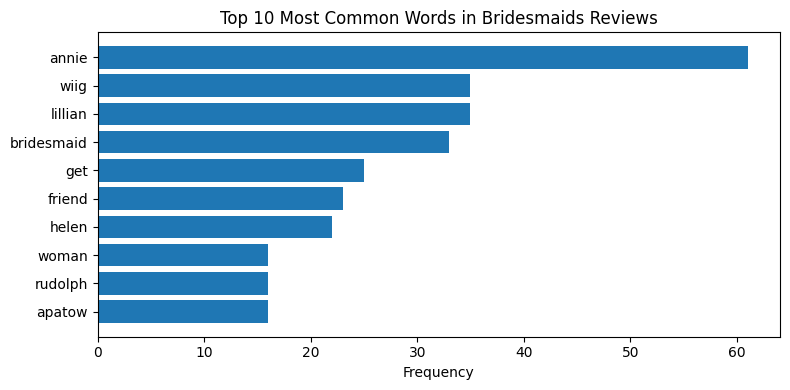

In [ ]:
# Cell 5: Apply Cleaning to Bridesmaids Subset

from tqdm.notebook import tqdm
tqdm.pandas()  # enable progress bar for .apply

docs_subset = docs_subset.copy()  # avoid SettingWithCopyWarning

#  Apply cleaning pipeline with progress
docs_subset['Cleaned_Text'] = docs_subset['Text'].progress_apply(clean_doc)

#  Display cleaned sample output
print("\nCleaned sample reviews:")
display(docs_subset[['Doc_ID', 'Movie Title', 'Review Type (pos or neg)', 'Cleaned_Text']].head(3))

# --- Word frequency summary
word_freq = counter_word(docs_subset['Cleaned_Text'])
print("\nTop 15 most common words across 10 docs:")
for w, c in word_freq.most_common(15):
    print(f"{w:<12} {c}")

# visualize top 10 words
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
top_words = word_freq.most_common(10)
plt.barh([w for w, _ in top_words][::-1], [c for _, c in top_words][::-1])
plt.title("Top 10 Most Common Words in Bridesmaids Reviews")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



## Knowledge Context Graph Functions

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Set, Tuple
import numpy as np
import pandas as pd

# Function: Map / Merge Edges

def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    """
    Unifies synonymous or duplicate edge labels.
    Example: merge {'directed', 'directed by'} into 'directed by'
    """
    before = sum(df['edge'] == map_to)
    df['edge'] = np.where(df['edge'].isin(map_from), map_to, df['edge'])
    after = sum(df['edge'] == map_to)
    print(f"Mapped edges {map_from} → '{map_to}' | Before: {before} | After: {after}")

# Function: Map / Merge Sources and Targets

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    """
    Unifies synonymous entity names across reviews.
    Example: merge {'Kristen Wiig', 'Wiig'} into 'Kristen Wiig'
    """
    before = sum(df['source'] == map_to) + sum(df['target'] == map_to)
    df['source'] = np.where(df['source'].isin(map_from), map_to, df['source'])
    df['target'] = np.where(df['target'].isin(map_from), map_to, df['target'])
    after = sum(df['source'] == map_to) + sum(df['target'] == map_to)
    print(f"Mapped entities {map_from} → '{map_to}' | Before: {before} | After: {after}")

# Function: Retrieve Graph Neighborhood
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    """
    Expands from a set of source nodes outward along specified edge types.
    Example: find all nodes within 2 hops of 'Bridesmaids (2011)' via 'expresses theme'
    """
    output = []
    for d in range(depth):
        if edge_types:
            rows = df[(df['edge'].isin(edge_types)) &
                      ((df['source'].isin(sources)) | (df['target'].isin(sources)))].copy()
        else:
            rows = df[(df['source'].isin(sources)) | (df['target'].isin(sources))].copy()
        output.append(rows)
        sources = set(rows['target']).union(set(rows['source']))
    return pd.concat(output).drop_duplicates()
# Function: Find Entities Matching Text Patterns
def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters graph nodes containing specific text patterns.
    Example: find all entities mentioning 'Wiig' or 'director'
    """
    mask = np.zeros(df.shape[0], dtype=bool)
    for pattern in patterns:
        mask |= df['source'].str.contains(pattern, case=False, na=False)
        mask |= df['target'].str.contains(pattern, case=False, na=False)
    return df[mask]

# Function: Plot Graph
def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool = True):
    """
    Visualizes the ontology or extracted knowledge graph.
    Each row of df should contain: source, target, and edge columns.
    """
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr="edge", create_using=nx.MultiDiGraph())
    plt.figure(figsize=figsize)

    pos = nx.circular_layout(graph) if use_circular else nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color="skyblue", node_size=2200, font_size=10, edge_cmap=plt.cm.Blues)

    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, "edge"), font_size=8)
    plt.title("Knowledge Graph Visualization — Bridesmaids (2011)", fontsize=14)
    plt.show()

# Function: Summary Helpers
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    """
    Returns the most common entities appearing as sources or targets.
    """
    combined_counts = Counter(df['source']) + Counter(df['target'])
    return combined_counts.most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    """
    Returns the most common relationship (edge) types.
    """
    return Counter(df['edge']).most_common(top)

# Function: Partition Dataset
def get_dataset_partitions_pd(df: pd.DataFrame, train_split=0.8, val_split=0.10, test_split=0.10):
    """
    Splits graph-based datasets for machine learning tasks (e.g., relation classification).
    """
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((train_split + val_split) * len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

print(" Knowledge Graph utilities (mapping, search, plot, partition) ready for Bridesmaids ontology.")


 Knowledge Graph utilities (mapping, search, plot, partition) ready for Bridesmaids ontology.


## Entity Extraction Functions

In [ ]:
import spacy
from spacy.matcher import Matcher

# Ensure spaCy model is loaded
try:
    nlp
except NameError:
    nlp = spacy.load('en_core_web_lg')

# Function: Extract Entity Pair (ent1, ent2)
def get_entities(sent: str):
    """
    Identifies two primary entities in a sentence using dependency parsing.
    Example:
      'Paul Feig directed Bridesmaids' → ['Paul Feig', 'Bridesmaids']
    """
    ent1, ent2 = "", ""
    prv_tok_dep, prv_tok_text = "", ""
    prefix, modifier = "", ""

    for tok in nlp(sent):
        if tok.dep_ != "punct":
            # Handle compound nouns (e.g., "Kristen Wiig")
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # Handle modifiers (e.g., "romantic subplot")
            if tok.dep_.endswith("mod"):
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            # Detect subject
            if "subj" in tok.dep_:
                ent1 = (modifier + " " + prefix + " " + tok.text).strip()
                prefix = modifier = ""

            # Detect object
            if "obj" in tok.dep_:
                ent2 = (modifier + " " + prefix + " " + tok.text).strip()

            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

# Function: Extract Relation (verb phrase)
def get_relation(sent: str):
    """
    Extracts the main verb or verb phrase connecting entities.
    Example:
      'Paul Feig directed Bridesmaids' → 'directed'
    """
    try:
        doc = nlp(sent)
        matcher = Matcher(nlp.vocab)

        # Pattern to identify verbs and optional prepositions/adjectives
        pattern = [
            {'DEP': 'ROOT'},
            {'DEP': 'prep', 'OP': "?"},
            {'DEP': 'agent', 'OP': "?"},
            {'POS': 'ADJ', 'OP': "?"}
        ]
        matcher.add("relation_pattern", [pattern])

        matches = matcher(doc)
        if matches:
            last_match = matches[-1]
            span = doc[last_match[1]: last_match[2]]
            return span.text
        else:
            return ""
    except Exception:
        return ""
# Function: Extract Subject–Verb–Object Triplet
def get_subject_verb_object(sent: str):
    """
    Simplified triplet extractor for sentences.
    Example:
      'Annie Mumolo wrote Bridesmaids' → ['Annie Mumolo', 'wrote', 'Bridesmaids']
    """
    ent1, ent2, root = "", "", ""
    for tok in nlp(sent):
        if tok.dep_ == 'ROOT':
            root = tok.text
        elif tok.dep_ == "nsubj":
            ent1 = tok.text
        elif tok.dep_ == "dobj":
            ent2 = tok.text

        if ent1 and ent2 and root:
            break

    return [ent1.strip(), root.strip(), ent2.strip()]

print(" Information Extraction functions loaded — ready to extract SVO triples from Bridesmaids reviews.")


 Information Extraction functions loaded — ready to extract SVO triples from Bridesmaids reviews.


## Visualization Utility Functions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Confusion Matrix

def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    """
    Draws a labeled confusion matrix for classification results.
    Used after evaluating your Bidirectional RNN or sentiment model.
    """
    mtx = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(mtx, index=CLASSES_LIST, columns=CLASSES_LIST)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.75, linecolor='white')
    plt.title("Confusion Matrix — Bridesmaids (2011) Sentiment / Relation Model", fontsize=13)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Training History Plot (Single Metric)
def plot_graphs(history, metric):
    """
    Plots a metric (e.g., 'accuracy', 'loss') and its validation curve over epochs.
    """
    plt.figure(figsize=(7,5))
    plt.plot(history.history[metric], label=f"Training {metric}")
    plt.plot(history.history['val_'+metric], label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} per Epoch — Bridesmaids RNN")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combined Curves for Model Training
def display_training_curves(training, validation, title, subplot):
    """
    For side-by-side visualization of training vs validation metrics.
    """
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('Model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'])
    plt.tight_layout()

print(" Visualization utilities ready — use after RNN training or graph-based classification.")


 Visualization utilities ready — use after RNN training or graph-based classification.


In [ ]:

triples = []

for review in docs_subset["Cleaned_Text"]:
    for sent in nlp(review).sents:
        ent_pair = get_entities(sent.text)
        relation = get_relation(sent.text)
        if ent_pair[0] and ent_pair[1] and relation:
            triples.append({
                "source": ent_pair[0],
                "edge": relation,
                "target": ent_pair[1]
            })

kg_df = pd.DataFrame(triples)
display(kg_df.head(10))

print(f" Extracted {len(kg_df)} subject–verb–object triples.")


,source,edge,target
0,set fulfilling set role,asks,naturally maid honor annie
1,dysfunctional rita wendi mclendon,announces,mouthed child
2,yet funniness naturalness,pose biggest,best food poisoning ordeal
3,consumes,chooses wrong,film
4,poor behavior actress,worsens,impressive balance broad
5,cop pull officer chris,got,irish comedian
6,first lillian sip class,complain,extended airplane sequence
7,lillian country club,chooses,lillian annie talk megan
8,romantic comedy sitcom,know,mad demeanor time
9,diary,announces,light business love chuckle


 Extracted 20 subject–verb–object triples.


## Exploratory Data Analysis

In [ ]:
def get_sentences(text):
    """
    Splits a document into sentences using the spaCy model.
    Returns a list of sentence strings.
    """
    return [sent.text.strip() for sent in nlp(text).sents]

def get_lemmas(text, stopwords_set):
    """
    Lemmatizes tokens in text and removes stopwords/non-alphabetic tokens.
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords_set]

# --- Tokenize sentences in each review ---
docs_subset['raw_sentences'] = docs_subset['Text'].apply(get_sentences)

# --- Combine standard + spaCy stopword lists ---
default_stopwords = (
    set(nltk.corpus.stopwords.words('english'))
    .union(set(nlp.Defaults.stop_words))
    .union({' ', ''})
)

# --- Lemmatize words while removing stopwords ---
docs_subset['lemmas'] = docs_subset['Text'].apply(lambda x: get_lemmas(x, default_stopwords))

# --- Display sample output ---
display(docs_subset[['Movie Title', 'Genre of Movie', 'Review Type (pos or neg)', 'lemmas']].head(3).T)

print(" Sentence tokenization and lemmatization complete, ready for linguistic feature analysis.")




,0,1,2
Movie Title,Bridesmaids,Bridesmaids,Bridesmaids
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Positive,Negative,Positive
lemmas,"[pair, simple, question, ask, come, r, rate, h...","[bridesmaid, feel, good, teen, sex, farce, ini...","[align, perfectly, judd, apatow, heartfelt, ra..."


 Sentence tokenization and lemmatization complete, ready for linguistic feature analysis.


In [ ]:
bridesmaids_df = df[df["Movie Title"].str.contains("Bridesmaids", case=False)]
print("Number of Bridesmaids reviews:", bridesmaids_df.shape[0])



Number of Bridesmaids reviews: 10


## Reassemble Leminized Words

In [ ]:

# Cell 10: Reassemble Lemmatized Words


docs_subset['lemmas_joined'] = docs_subset['lemmas'].apply(lambda x: ' '.join(x))
display(docs_subset[['Movie Title', 'lemmas_joined']].head())

print(" Lemmatized text reassembled — ready for vectorization or transformer encoding.")



,Movie Title,lemmas_joined
0,Bridesmaids,pair simple question ask come r rate hollywood...
1,Bridesmaids,bridesmaid feel good teen sex farce initially ...
2,Bridesmaids,align perfectly judd apatow heartfelt raunchy ...
3,Bridesmaids,annie kristen wiig bad time bakery recently fo...
4,Bridesmaids,go start review time saver word serve litmus t...


 Lemmatized text reassembled — ready for vectorization or transformer encoding.


## Vocabulary Data Wrangling

All Word Vocabulary Size: 1212
Curated Vocabulary Size: 345


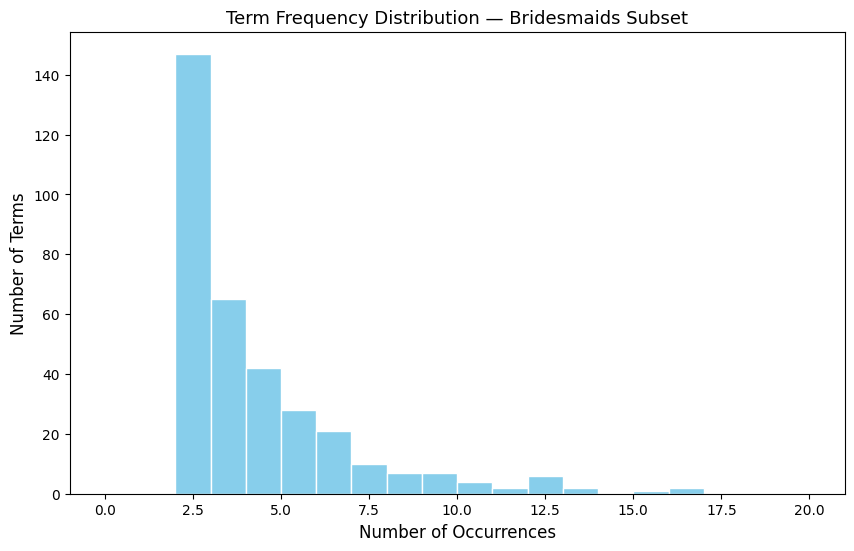

 Vocabulary refinement complete. Lemmatized Bridesmaids subset updated.


,Movie Title,lemmas_joined
0,Bridesmaids,simple question ask come r rate hollywood come...
1,Bridesmaids,bridesmaid feel sex initially pass cast old lo...
2,Bridesmaids,align perfectly judd apatow raunchy comedy lik...


In [ ]:

# Cell 11: Vocabulary Data Wrangling


from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# --- Initial Vocabulary (all tokens) ---
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(docs_subset['lemmas_joined'])
doc_term_matrix = transformed_documents.todense()

doc_term_df = pd.DataFrame(
    doc_term_matrix,
    columns=vectorizer.get_feature_names_out(),
    index=docs_subset['Doc_ID']
)

print(f"All Word Vocabulary Size: {doc_term_df.shape[1]}")
all_words = set(doc_term_df.columns)

# --- Curated Vocabulary (filter out rare/common terms) ---
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=2, max_df=0.8)
transformed_documents = vectorizer.fit_transform(docs_subset['lemmas_joined'])
doc_term_matrix = transformed_documents.todense()

doc_term_df = pd.DataFrame(
    doc_term_matrix,
    columns=vectorizer.get_feature_names_out(),
    index=docs_subset['Doc_ID']
)

print(f"Curated Vocabulary Size: {doc_term_df.shape[1]}")
vocabulary = set(doc_term_df.columns)

# --- Words to Remove (stopwords + filtered-out words) ---
words_to_remove = default_stopwords.union(all_words - vocabulary)

# --- Histogram of Term Frequencies ---
plt.figure(figsize=(10, 6))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 20), bins=20, color="skyblue", edgecolor="white")
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("Number of Terms", fontsize=12)
plt.title("Term Frequency Distribution — Bridesmaids Subset", fontsize=13)
plt.show()

# --- Retokenize subset after vocabulary refinement ---
docs_subset['lemmas'] = docs_subset['Text'].apply(lambda x: get_lemmas(x, words_to_remove))
docs_subset['lemmas_joined'] = docs_subset['lemmas'].apply(lambda x: ' '.join(x))

print(" Vocabulary refinement complete. Lemmatized Bridesmaids subset updated.")
display(docs_subset[['Movie Title', 'lemmas_joined']].head(3))


## Get Lemmatized and Filtered Sentences

In [ ]:

# Cell 12: Get Lemmatized and Filtered Sentences


def lemmatize_sentence(sentence, words_to_remove):
    """
    Lemmatizes an individual sentence and removes stopwords/irrelevant tokens.
    """
    doc = nlp(sentence.lower())
    return ' '.join([
        token.lemma_ for token in doc
        if token.is_alpha and token.text not in words_to_remove
    ])

docs_subset['sentences_lemmatized'] = docs_subset['raw_sentences'].apply(
    lambda sentences: [lemmatize_sentence(s, words_to_remove) for s in sentences]
)

# --- Inspect a sample of the transformed data ---
display(docs_subset[['Movie Title', 'sentences_lemmatized']].head().T)

print(" Sentence-level lemmatization and filtering complete — ready for entity–relation extraction.")



,0,1,2,3,4
Movie Title,Bridesmaids,Bridesmaids,Bridesmaids,Bridesmaids,Bridesmaids
sentences_lemmatized,[simple question ask come r rate hollywood com...,"[bridesmaid feel sex initially pass, cast old ...",[align perfectly judd apatow raunchy comedy li...,"[bad time, bakery fold lose lot money jewelry ...","[go start review time word serve bridesmaid, m..."


 Sentence-level lemmatization and filtering complete — ready for entity–relation extraction.


## Review Documents By Movie Title

In [ ]:

# Cell 13: Review Documents by Movie Title


print("Unique Movie Titles in Subset:")
print(docs_subset['Movie Title'].unique())

print(f"\nNumber of Bridesmaids Reviews: {docs_subset.shape[0]}")
display(docs_subset[['Movie Title', 'Review Type (pos or neg)', 'lemmas_joined']].head(3).T)
""

Unique Movie Titles in Subset:
['Bridesmaids']

Number of Bridesmaids Reviews: 10


,0,1,2
Movie Title,Bridesmaids,Bridesmaids,Bridesmaids
Review Type (pos or neg),Positive,Negative,Positive
lemmas_joined,simple question ask come r rate hollywood come...,bridesmaid feel sex initially pass cast old lo...,align perfectly judd apatow raunchy comedy lik...


''

## Knowledge Graph Extraction

In [ ]:

# Cell 14: Knowledge Graph Extraction — Entity Pair Identification


from tqdm import tqdm

# --- Combine all Bridesmaids sentences into one list ---
corpus_text_sentences = [sentence for review in docs_subset['raw_sentences'] for sentence in review]

print(f"Total number of sentences in Bridesmaids reviews: {len(corpus_text_sentences)}")

# --- Inspect a sample sentence ---
example_sentence = corpus_text_sentences[5]
print("\nExample Sentence:")
print(example_sentence)

# --- Run spaCy on sample for demonstration ---
doc = nlp(example_sentence)
print("\nNamed Entities Detected:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_})")

# --- Extract entity pairs (subject/object) from all sentences ---
entity_pairs = [get_entities(sentence) for sentence in tqdm(corpus_text_sentences, desc="Extracting entity pairs")]

# --- Display first few entity pairs ---
print("\nSample extracted entity pairs (subject, object):")
for pair in entity_pairs[:10]:
    print(pair)



Total number of sentences in Bridesmaids reviews: 239

Example Sentence:
Hell no!

Named Entities Detected:


Extracting entity pairs: 100%|██████████| 239/239 [00:04<00:00, 56.02it/s]


Sample extracted entity pairs (subject, object):
['why  girls', 'some']
['who', 'bad  fun']
['men', 'scandalous  fun']
['single  that', '']
['women', 'sophomoric  behavior']
['', '']
['you', 'ever bachelorette town']
['just Division you', 'just Division Street']
['lady gangs', 'that']
['just  that', 'far  men']


### Create DataFrame (Source, Target, Edge)

In [ ]:

# Cell 15: Build the Bridesmaids Knowledge Graph DataFrame


# --- Extract relationship (edge) terms for each sentence ---
relations = [get_relation(sentence) for sentence in tqdm(corpus_text_sentences, desc="Extracting relations")]

# --- Extract subjects and objects from previously built entity pairs ---
source = [pair[0] for pair in entity_pairs]
target = [pair[1] for pair in entity_pairs]

# --- Combine into one DataFrame ---
kg_df = pd.DataFrame({
    'source': source,
    'edge': relations,
    'target': target
})

# --- Drop empty or malformed rows ---
kg_df = kg_df[(kg_df['source'] != "") & (kg_df['target'] != "") & (kg_df['edge'].notnull())]
kg_df = kg_df.reset_index(drop=True)

print(f" Knowledge Graph DataFrame created — {len(kg_df)} valid triples extracted.\n")
display(kg_df.head(10))


Extracting relations: 100%|██████████| 239/239 [00:05<00:00, 41.63it/s]

 Knowledge Graph DataFrame created — 200 valid triples extracted.



,source,edge,target
0,why girls,get,some
1,who,'s,bad fun
2,men,Are,scandalous fun
3,women,Are,sophomoric behavior
4,you,crossed,ever bachelorette town
5,just Division you,spend,just Division Street
6,lady gangs,get drunk,that
7,just that,'s,far men
8,girls,lets,debauchery
9,results,are hilarious,surprising places


In [ ]:
# Helper Function: Match BERT-Extracted Entities with Knowledge Graph Nodes
def find_sources_and_targets_with_patterns(entity_list, kg_df):
    """
    Filters the knowledge graph DataFrame (kg_df) to retain only
    relationships where either the source or target contains
    one of the detected entities.

    Parameters:
        entity_list (list): List of entity strings from NER.
        kg_df (DataFrame): DataFrame with columns ['source', 'edge', 'target'].

    Returns:
        DataFrame: Subset of kg_df filtered by matching entities.
    """
    if kg_df is None or kg_df.empty:
        print(" Knowledge graph is empty or undefined.")
        return pd.DataFrame()

    # Lowercase for robust matching
    entity_list = [e.lower() for e in entity_list if isinstance(e, str)]

    filtered_df = kg_df[
        kg_df['source'].str.lower().apply(lambda x: any(ent in x for ent in entity_list)) |
        kg_df['target'].str.lower().apply(lambda x: any(ent in x for ent in entity_list))
    ]

    return filtered_df


In [ ]:
# Helper Function: Visualize Knowledge Graph
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(df, use_circular=False):
    """
    Visualizes the filtered knowledge graph using NetworkX.
    Displays source–target relationships as nodes and labeled edges.

    Parameters:
        df (DataFrame): DataFrame containing ['source', 'edge', 'target'] columns.
        use_circular (bool): Use circular layout if True, else spring layout.
    """
    if df is None or df.empty:
        print("No relationships found to visualize.")
        return

    # Initialize graph
    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='edge', create_using=nx.DiGraph())

    # Choose layout
    pos = nx.circular_layout(G) if use_circular else nx.spring_layout(G, k=0.5, iterations=50)

    # Plot graph
    plt.figure(figsize=(10, 7))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color="#A8D5BA",
        node_size=1800,
        edge_color="#555555",
        font_size=9,
        font_weight='bold',
        arrows=True,
        arrowsize=15
    )

    # Add edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'edge'),
                                 font_color='darkred', font_size=8)

    plt.title("BERT-Aligned Knowledge Graph — Bridesmaids", fontsize=13, pad=20)
    plt.show()


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 BERT NER pipeline loaded successfully.
Processing NER for: Bridesmaids (10 reviews)
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids
 Extracting entities for: Bridesmaids

 NER processing completed for all selected reviews.

Sample of extracted entities for 'Bridesmaids':


,entity_group,score,word,start,end
0,MISC,0.986432,Bridesmaids,75,86
1,MISC,0.989189,The Hangover,320,332
2,MISC,0.986383,Cinco de Mayo,451,464
3,PER,0.739063,Judd Apato,825,835
4,ORG,0.451273,##w,835,836


Total unique NER entities: 14
Example entities: ['wii', 'maya rudolph', 'bridesmaids', 'the hangover', 'rudolph', 'wiig', 'rose byrne', 'cinco de mayo', 'saturday night live', '##w']

Filtered Knowledge Graph contains 21 relationships matching BERT-detected entities.



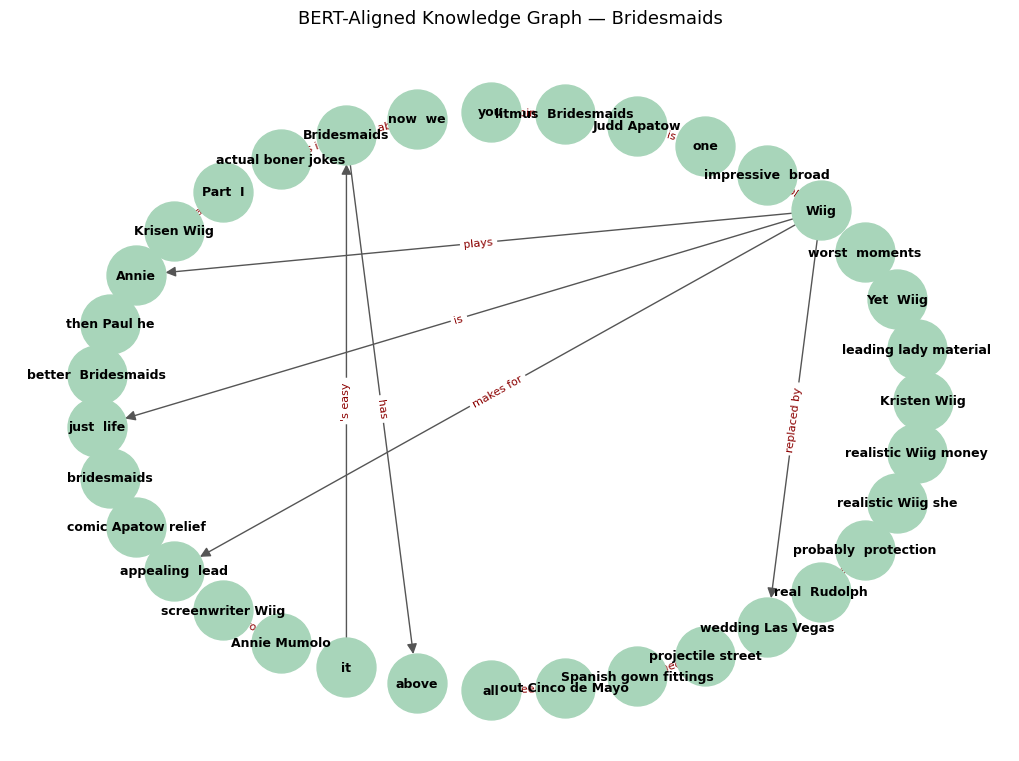

In [ ]:
# Cell 16: BERT Named Entity Recognition (NER) Integration


from transformers import pipeline

# Setup: BERT NER Pipeline
def setup_ner_pipeline(model_name="dbmdz/bert-large-cased-finetuned-conll03-english"):
    """
    Initialize a BERT-based NER pipeline.
    Model identifies PER, LOC, ORG, MISC entities.
    """
    try:
        ner_pipeline = pipeline("ner", model=model_name, aggregation_strategy="simple")
        print(" BERT NER pipeline loaded successfully.")
        return ner_pipeline
    except Exception as e:
        print(f" Error setting up NER pipeline: {e}")
        return None

# Create NER pipeline
ner_pipeline = setup_ner_pipeline()

# Prepare Data for NER
# Rename for consistency with NER function expectations
data_raw = docs_subset.rename(columns={'Movie Title': 'title', 'raw_sentences': 'content'}).copy()

# Filter for Bridesmaids (you can easily switch titles here)
specific_title = 'Bridesmaids'

# Extract just the Bridesmaids subset
data = data_raw.query("title.str.contains(@specific_title, case=False)", engine='python').copy()
print(f"Processing NER for: {specific_title} ({data.shape[0]} reviews)")

# Perform NER
def perform_ner_and_store_in_df(data, ner_pipeline):
    """
    Perform NER on all documents and store results per movie.
    Expects a DataFrame with 'title' and 'content' columns.
    """
    if data is not None and ner_pipeline is not None:
        titles = data['title']
        contents = data['content']
        df_dict = {}

        for title, text_list in zip(titles, contents):
            print(f" Extracting entities for: {title}")
            joined_text = " ".join(text_list)  # join all sentences
            entities = ner_pipeline(joined_text)
            df_dict[title] = pd.DataFrame(entities)

        print("\n NER processing completed for all selected reviews.")
        return df_dict
    else:
        print(" Data or NER pipeline not initialized.")
        return {}

# Run BERT NER on Bridesmaids reviews
df_dict = perform_ner_and_store_in_df(data, ner_pipeline)

# Examine NER Output
if specific_title in df_dict:
    ner_df = df_dict[specific_title]
    print(f"\nSample of extracted entities for '{specific_title}':")
    display(ner_df.head())
else:
    print("Title not found in NER results.")

# Extract Entity Words for Ontology Cross-Reference
all_entities = []

if specific_title in df_dict:
    df_iter = df_dict[specific_title]
    for _, row in df_iter.iterrows():
        if isinstance(row['word'], str):
            all_entities.append(row['word'].lower())

print(f"Total unique NER entities: {len(set(all_entities))}")
print("Example entities:", list(set(all_entities))[:10])

# Filter Knowledge Graph by NER Entities
entities_kg_df = find_sources_and_targets_with_patterns(all_entities, kg_df)

print(f"\nFiltered Knowledge Graph contains {entities_kg_df.shape[0]} relationships "
      f"matching BERT-detected entities.\n")

# Visualize BERT-aligned subgraph
plot_graph(entities_kg_df, use_circular=True)



## OpenAI Entity Extraction (Optional Enhancement for Bridesmaids Ontology)


 Processing sentence 1/5: [There's a pair of simple questions to ask when it comes to R-rated Hollywood comedies: Why do guys get to have all the ...
→ Extracted 4 triple(s). Running total: 4

 Processing sentence 2/5: Save for a pair of atrocious Sex and the City romps, if you take the modern and the classic span of raunchy R-rated come...
→ Extracted 3 triple(s). Running total: 7

 Processing sentence 3/5: Are men the only ones capable of all that scandalous fun?...
→ Extracted 1 triple(s). Running total: 8

 Processing sentence 4/5: Any reasonable college student, reformed (or are they?) college graduate, or Beyonce "single lady" knows that's not true...
→ Extracted 3 triple(s). Running total: 11

 Processing sentence 5/5: Are women not capable of having a filthy mind and the initiative to pull off their own sophomoric behavior?...
→ Extracted 3 triple(s). Running total: 14

 Extraction complete. Example output:


,source,edge,target
0,pair,ask,questions
1,it,comes to,R-rated Hollywood comedies
2,guys,get to have,all the fun
3,girls,have,some too
4,pair,save for,atrocious Sex and the City romps


Cleaned OpenAI Graph: 14 relationships


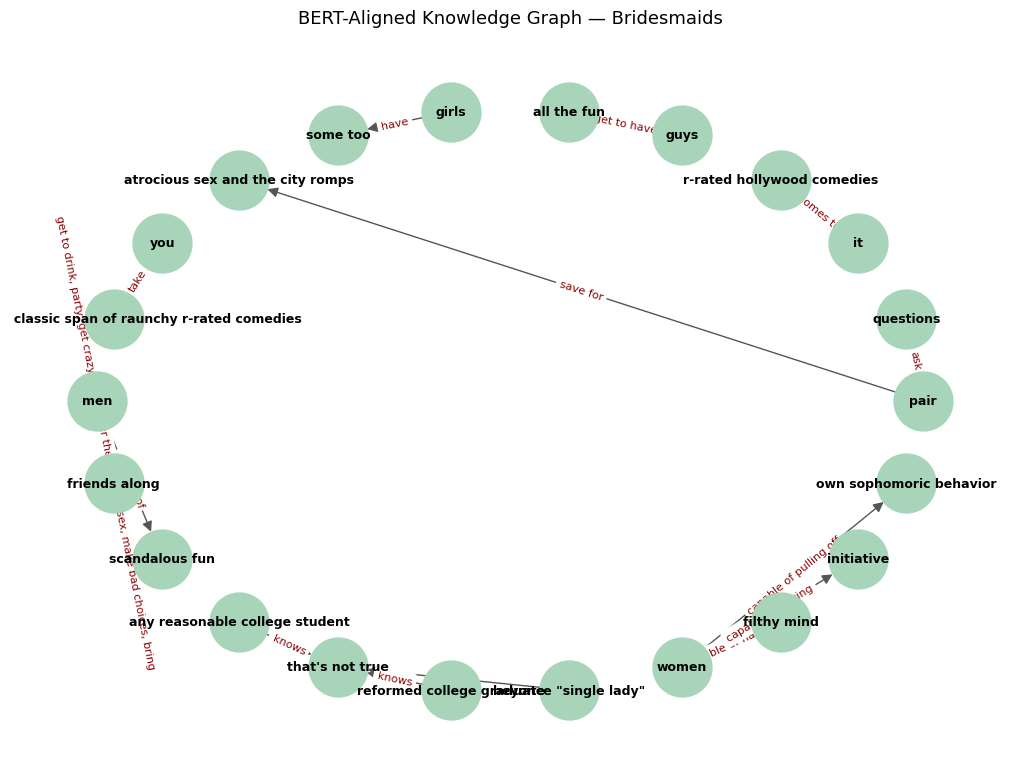

In [ ]:
# Cell 17 (Fixed): OpenAI Entity Extraction (Optional)


!pip install openai --quiet

from openai import OpenAI
import re, time
from io import StringIO
import pandas as pd

#   Parse OpenAI Response into a DataFrame
def parse_openai_response(response_text: str) -> pd.DataFrame:
    if ";" in response_text:
        response_text = re.sub(r'\d+\.', '', response_text)
        data = StringIO(response_text)
        df = pd.read_csv(data, sep=';', names=['source', 'edge', 'target'])
        df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
        return df
    return pd.DataFrame(columns=['source', 'edge', 'target'])

#  GPT-Based Triple Extraction (modern API)
def parse_sentences_openai(sentences, restart=0, model="gpt-3.5-turbo", delay=5):
    """
    Calls the OpenAI API for each sentence to extract (Subject; Verb; Object) triples.
    """
    global global_kg_df2
    client = OpenAI(api_key="KeyRemoved")

    for i in range(restart, len(sentences)):
        sentence = sentences[i].strip()
        if not sentence:
            continue

        print(f"\n Processing sentence {i+1}/{len(sentences)}: {sentence[:120]}...")

        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system",
                     "content": "Extract clear (Subject; Verb; Object) triples from English text. "
                                "Do not number them. Dereference pronouns. "
                                "Output each triple as one line formatted like: Subject; Verb; Object"},
                    {"role": "user", "content": sentence},
                ],
                temperature=0,
                max_tokens=200,
            )

            raw_response = response.choices[0].message.content
            sentence_df = parse_openai_response(raw_response)
            global_kg_df2 = pd.concat([global_kg_df2, sentence_df], ignore_index=True)
            print(f"→ Extracted {len(sentence_df)} triple(s). Running total: {len(global_kg_df2)}")

        except Exception as e:
            print(f" API error at sentence {i}: {e}")
            break

        time.sleep(delay)

    return global_kg_df2

#   Initialize and Run
global_kg_df2 = pd.DataFrame(columns=["source", "edge", "target"])
test_sentences = corpus_text_sentences[:5]
parse_sentences_openai(test_sentences)

print("\n Extraction complete. Example output:")
display(global_kg_df2.head())

#   Clean & Visualize
for col in ["source", "edge", "target"]:
    global_kg_df2[col] = global_kg_df2[col].astype(str).str.lower().str.strip()

global_kg_df2 = global_kg_df2.replace({"nan": ""})
global_kg_df2 = global_kg_df2[(global_kg_df2["source"] != "") & (global_kg_df2["target"] != "")]

print(f"Cleaned OpenAI Graph: {global_kg_df2.shape[0]} relationships")
plot_graph(global_kg_df2, use_circular=True)



In [ ]:
# ==========================================================
# PART 2 – RNN & LSTM Genre Classification (Prof Style)
# ==========================================================
# 8 experiments: 4 RNN + 4 LSTM
# Full class corpus (200 reviews, 4 genres)
# Train/Val/Test: 160/20/20
# Confusion matrices, results table, training curves
# ==========================================================


In [ ]:
# --------------------------------------------------
# 1. Imports (prof style)
# --------------------------------------------------
import pandas as pd, numpy as np, re, string, warnings, nltk
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from typing import List, Set, Tuple

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

warnings.filterwarnings('ignore')
print("All imports complete.")

All imports complete.


In [ ]:
# --------------------------------------------------
# 2. Load class corpus (from GitHub)
# --------------------------------------------------
url = "https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20250924.csv"
df = pd.read_csv(url)
print(f"Loaded class corpus with shape: {df.shape}")
print("Columns:", list(df.columns))
print("\nUnique Genres in Corpus:", df["Genre of Movie"].unique())

Loaded class corpus with shape: (200, 8)
Columns: ['Doc_ID', 'DSI_Title', 'Submission File Name', 'Student Name', 'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title', 'Text']

Unique Genres in Corpus: ['Comedy' 'Sci-Fi' 'Horror' 'Action']


In [ ]:
# --------------------------------------------------
# 3. Preprocessing functions (prof style)
# --------------------------------------------------
def clean_doc(doc: str) -> str:
    doc = re.sub(r'[^a-zA-Z\s]', ' ', str(doc))
    tokens = word_tokenize(doc.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned'] = df['Text'].apply(clean_doc)
print("Text cleaning complete.")

Text cleaning complete.


In [ ]:
# --------------------------------------------------
# 4. Encode genre labels
# --------------------------------------------------
label_encoder = LabelEncoder()
df["genre_code"] = label_encoder.fit_transform(df["Genre of Movie"])
print("Genre classes:", label_encoder.classes_)

Genre classes: ['Action' 'Comedy' 'Horror' 'Sci-Fi']


In [ ]:
# --------------------------------------------------
# 5. Tokenize & pad
# --------------------------------------------------
MAX_WORDS = 10000
MAX_LEN = 200
BATCH_SIZE = 32

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned"])

X = pad_sequences(tokenizer.texts_to_sequences(df["cleaned"]),
                  maxlen=MAX_LEN, padding='post', truncating='post')
y = df["genre_code"].values

print(f"Tokenized & padded: X.shape = {X.shape}")

Tokenized & padded: X.shape = (200, 200)


In [ ]:
# --------------------------------------------------
# 6. Train/Val/Test split (160/20/20)
# --------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.8, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 160, Val: 20, Test: 20


In [ ]:
# --------------------------------------------------
# 7. Convert to tf.data.Dataset
# --------------------------------------------------
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(1000).batch(BATCH_SIZE, drop_remainder=False).cache().prefetch(AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .batch(BATCH_SIZE, drop_remainder=False).cache().prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .batch(BATCH_SIZE, drop_remainder=False).cache().prefetch(AUTOTUNE)

print("TensorFlow datasets ready.")

TensorFlow datasets ready.


In [ ]:
# --------------------------------------------------
# 8. Confusion matrix plot (prof style)
# --------------------------------------------------
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx, columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,
                cbar=False, ax=ax, cmap='Blues', linecolor='white')
    plt.title("Confusion Matrix", fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# --------------------------------------------------
# 9. Model configurations
# --------------------------------------------------
configs = [
    ("RNN_1L_32", SimpleRNN, 1, 32),
    ("RNN_1L_64", SimpleRNN, 1, 64),
    ("RNN_2L_32", SimpleRNN, 2, 32),
    ("RNN_2L_64", SimpleRNN, 2, 64),
    ("LSTM_1L_32", LSTM, 1, 32),
    ("LSTM_1L_64", LSTM, 1, 64),
    ("LSTM_2L_32", LSTM, 2, 32),
    ("LSTM_2L_64", LSTM, 2, 64),
]

EPOCHS = 30
PATIENCE = 3
EMBED_DIM = 128
VOCAB_SIZE = 10000
SEQ_LEN = 200

es = EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                   restore_best_weights=True, verbose=0)

results = []


=== TRAINING RNN_1L_32 ===

RNN_1L_32 – Test Acc: 0.3500


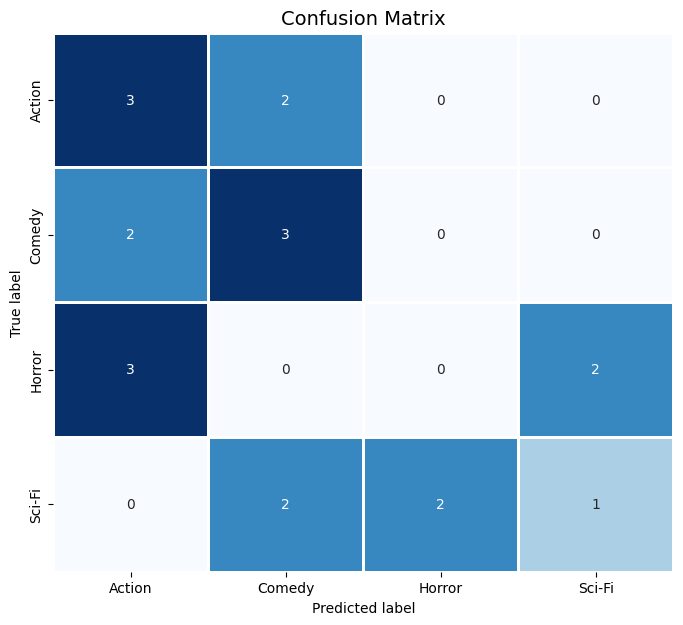


=== TRAINING RNN_1L_64 ===

RNN_1L_64 – Test Acc: 0.3000


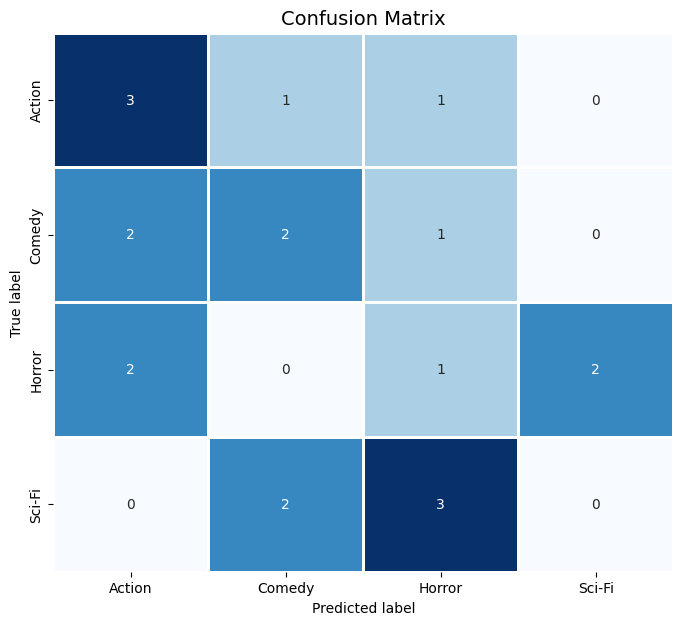


=== TRAINING RNN_2L_32 ===

RNN_2L_32 – Test Acc: 0.2500


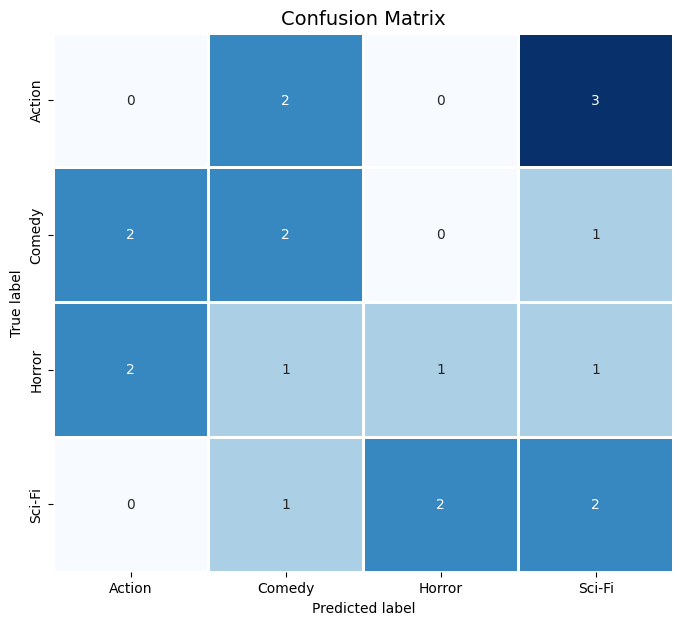


=== TRAINING RNN_2L_64 ===

RNN_2L_64 – Test Acc: 0.2000


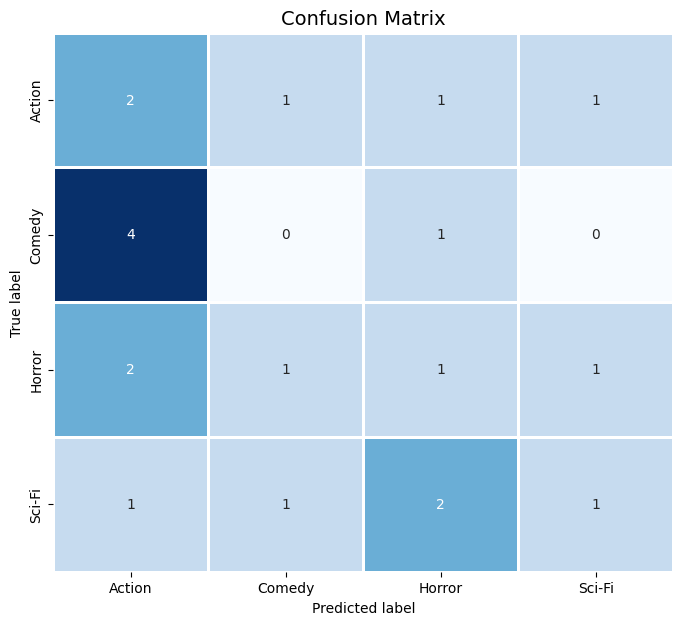


=== TRAINING LSTM_1L_32 ===

LSTM_1L_32 – Test Acc: 0.4500


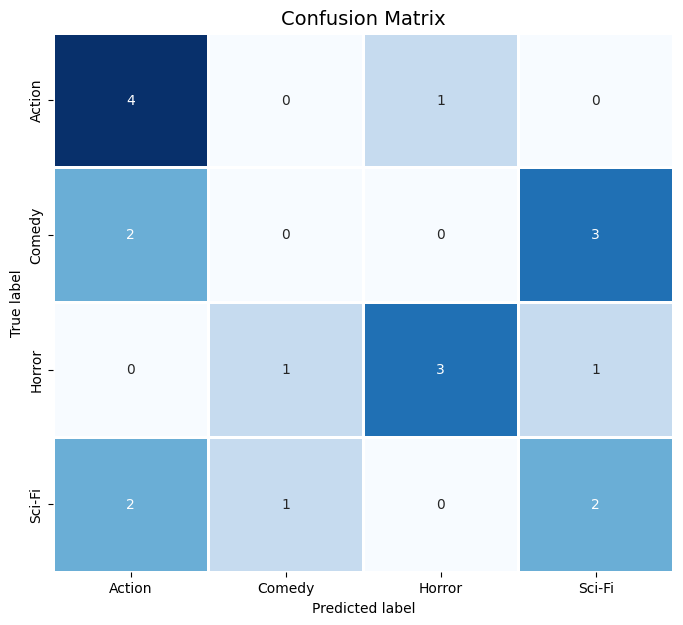


=== TRAINING LSTM_1L_64 ===

LSTM_1L_64 – Test Acc: 0.6500


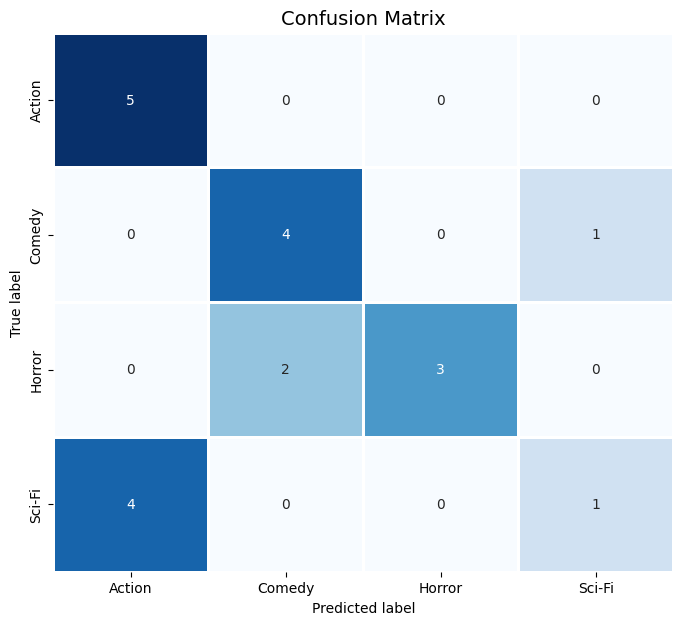


=== TRAINING LSTM_2L_32 ===

LSTM_2L_32 – Test Acc: 0.4500


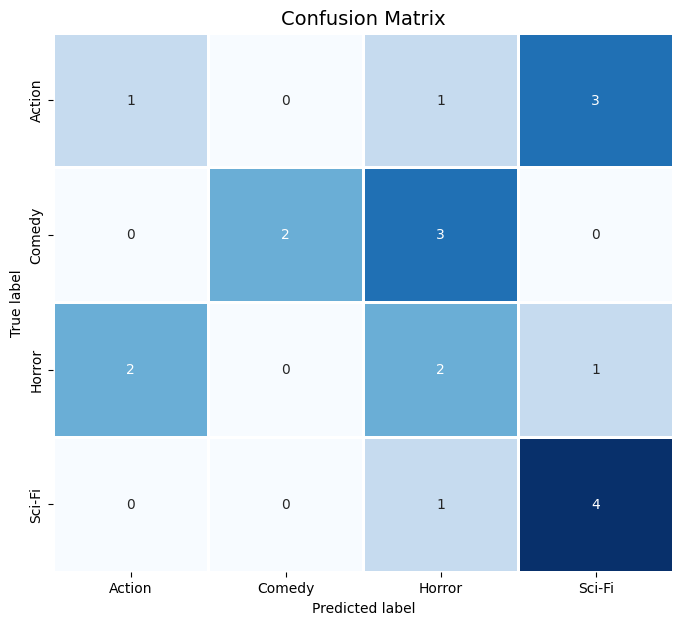


=== TRAINING LSTM_2L_64 ===

LSTM_2L_64 – Test Acc: 0.3500


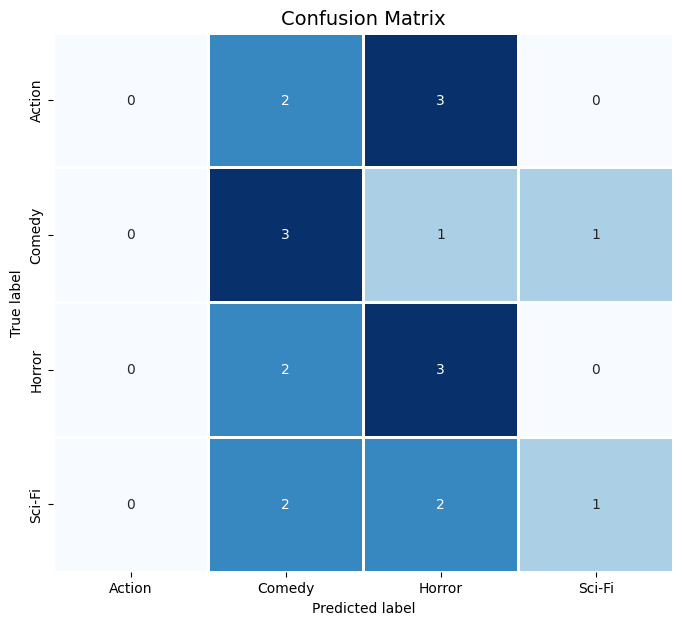

In [ ]:
# --------------------------------------------------
# 10. Train all 8 models
# --------------------------------------------------
for name, cell_type, layers, units in configs:
    print(f"\n=== TRAINING {name} ===")
    K.clear_session()

    model = Sequential(name=name)
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM,
                        input_length=SEQ_LEN, mask_zero=True))

    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(cell_type(units,
                            return_sequences=return_seq,
                            dropout=0.3,
                            recurrent_dropout=0.3))

    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=EPOCHS,
                        callbacks=[es],
                        verbose=0)

    # Evaluate
    train_loss, train_acc = model.evaluate(train_ds, verbose=0)
    test_loss,  test_acc  = model.evaluate(test_ds,  verbose=0)

    # Predictions
    y_train_pred = np.argmax(model.predict(train_ds, verbose=0), axis=1)
    y_test_pred  = np.argmax(model.predict(test_ds,  verbose=0), axis=1)
    y_train_true = np.concatenate([y for _, y in train_ds])
    y_test_true  = np.concatenate([y for _, y in test_ds])

    # Confusion matrices
    print(f"\n{name} – Test Acc: {test_acc:.4f}")
    plot_confusion_matrix_labeled(y_test_true, y_test_pred, label_encoder.classes_)

    # Save
    results.append({
        'Model'     : name,
        'Train Acc' : round(train_acc, 4),
        'Val Acc'   : round(max(history.history['val_accuracy']), 4),
        'Test Acc'  : round(test_acc, 4),
        'Epochs'    : len(history.history['accuracy'])
    })

In [ ]:
# --------------------------------------------------
# 11. Final results table
# --------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("FINAL RESULTS – TEST ACCURACY")
print("="*70)
display(results_df)
print("="*70)

best = results_df.iloc[0]
print(f"\nBEST MODEL: {best['Model']} – Test Acc: {best['Test Acc']}")


FINAL RESULTS – TEST ACCURACY


,Model,Train Acc,Val Acc,Test Acc,Epochs
0,LSTM_1L_64,0.9563,0.70,0.65,8
1,LSTM_1L_32,0.5875,0.35,0.45,3
2,LSTM_2L_32,0.6000,0.30,0.45,3
3,RNN_1L_32,0.4500,0.35,0.35,5
4,LSTM_2L_64,0.6687,0.55,0.35,3
5,RNN_1L_64,0.3375,0.25,0.30,3
6,RNN_2L_32,0.3000,0.20,0.25,3
7,RNN_2L_64,0.2562,0.40,0.20,5



BEST MODEL: LSTM_1L_64 – Test Acc: 0.65


Generating training curves for all 8 models...
Re-training RNN_1L_32 for curves...
Re-training RNN_1L_64 for curves...
Re-training RNN_2L_32 for curves...
Re-training RNN_2L_64 for curves...


Re-training LSTM_1L_32 for curves...


Re-training LSTM_1L_64 for curves...
Re-training LSTM_2L_32 for curves...
Re-training LSTM_2L_64 for curves...


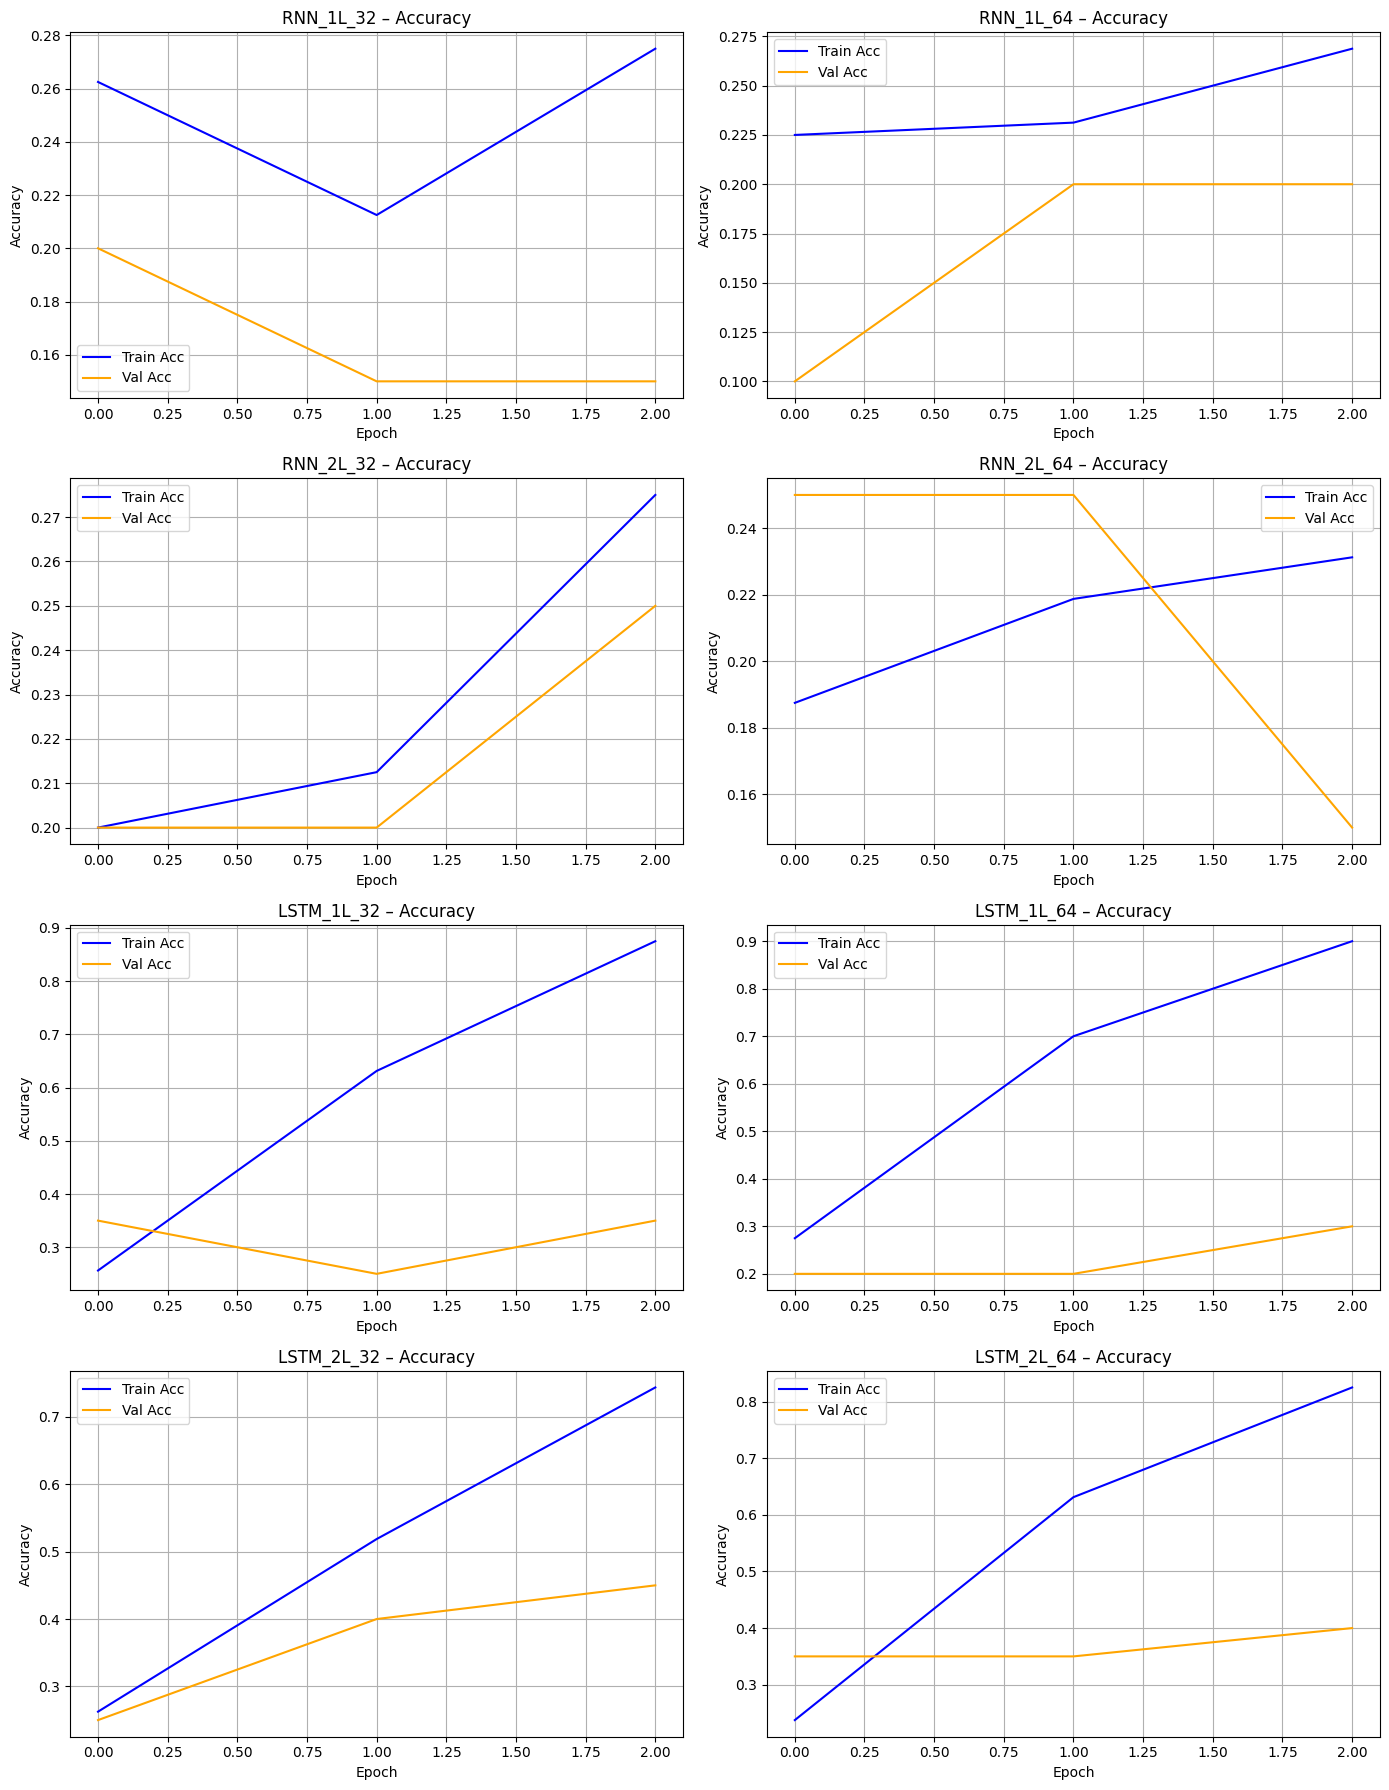

In [ ]:
# --------------------------------------------------
# 14. Training/Validation Curves for ALL 8 Models
# --------------------------------------------------
# Re-train each model to capture history
print("Generating training curves for all 8 models...")

fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.ravel()

for idx, (name, cell_type, layers, units) in enumerate(configs):
    print(f"Re-training {name} for curves...")
    K.clear_session()

    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQ_LEN, mask_zero=True))
    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(cell_type(units, return_sequences=return_seq,
                            dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=EPOCHS, callbacks=[es], verbose=0)

    # Accuracy
    axes[idx].plot(history.history['accuracy'], label='Train Acc', color='blue')
    axes[idx].plot(history.history['val_accuracy'], label='Val Acc', color='orange')
    axes[idx].set_title(f'{name} – Accuracy')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()